<a href="https://colab.research.google.com/github/sagardampba2022w/NLP_with_hugging_face/blob/main/nlp_hf_07_question_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets

In [41]:
#Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements(is_chapter7_v2=True)

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (526/526), done.
remote: Compressing objects: 100% (289/289), done.
remote: Total 526 (delta 251), reused 480 (delta 231), pack-reused 0
Receiving objects: 100% (526/526), 29.30 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (251/251), done.
/content/notebooks
⏳ Installing base requirements ...


Exception: 😭 Failed to install base requirements

In [42]:

from utils import *
setup_chapter()


No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.
Using transformers v4.39.3
Using datasets v2.20.0


In [43]:
%env TOKENIZERS_PARALLELISM=false


env: TOKENIZERS_PARALLELISM=false


# Question Answering

There are many flavors of QA, but the most common is extractive QA, which involves
questions whose answer can be identified as a span of text in a document, where the
document might be a web page, legal contract, or news article. The two-stage process
of first retrieving relevant documents and then extracting answers from them is also
the basis for many modern QA systems, including semantic search engines, intelli‐
gent assistants, and automated information extractors. In this chapter, we’ll apply this
process to tackle a common problem facing ecommerce websites: helping consumers
answer specific queries to evaluate a product. We’ll see that customer reviews can be
used as a rich and challenging source of information for QA, and along the way we’ll
learn how transformers act as powerful reading comprehension models that can
extract meaning from text. Let’s begin by fleshing out the use case.

This chapter focuses on extractive QA, but other forms of QA may
be more suitable for your use case. For example, community QA
involves gathering question-answer pairs that are generated by
users on forums like Stack Overflow, and then using semantic sim‐
ilarity search to find the closest matching answer to a new ques‐
tion. There is also long-form QA, which aims to generate complex
paragraph-length answers to open-ended questions like “Why is
the sky blue?” Remarkably, it is also possible to do QA over tables,
and transformer models like TAPAS can even perform aggrega‐
tions to produce the final answer!

# Building a Review-Based QA System

The Dataset
To build our QA system we’ll use the SubjQA dataset,2

which consists of more than
10,000 customer reviews in English about products and services in six domains: Trip‐
Advisor, Restaurants, Movies, Books, Electronics, and Grocery.

each review is associated with a question that can be answered using one
or more sentences from the review.

The interesting aspect of this dataset is that most of the questions and answers are
subjective; that is, they depend on the personal experience of the users.


First, the query is about “poor quality,” which is subjective and depends on the
user’s definition of quality. Second, important parts of the query do not appear in the
review at all, which means it cannot be answered with shortcuts like keyword search
or paraphrasing the input question. These features make SubjQA a realistic dataset to
benchmark our review-based QA models on,

To get started, let’s download the dataset from the Hugging Face Hub. As we did in
Chapter 4, we can use the get_dataset_config_names() function to find out which
subsets are available:

In [2]:
from datasets import get_dataset_config_names
domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [3]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", name="electronics")

In [4]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


To explore the dataset more easily, we’ll flatten these nested columns with the flatten() method and convert each split to a Pandas
DataFrame as follows:

In [5]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}


for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Let’s focus on these columns and take a look at a few of the training examples. We can
use the sample() method to select a random sample:

In [6]:
qa_cols = ["title", "question", "answers.text","answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


From these examples we can make a few observations. First, the questions are not
grammatically correct, which is quite common in the FAQ sections of ecommerce
websites. Second, an empty answers.text entry denotes “unanswerable” questions
whose answer cannot be found in the review. Finally, we can use the start index and
length of the answer span to slice out the span of text in the review that corresponds
to the answer:

In [7]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

Next, let’s get a feel for what types of questions are in the training set by counting the
questions that begin with a few common starting words:


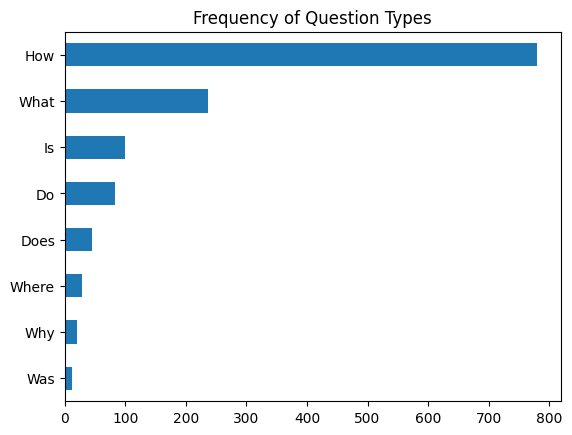

In [8]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]


pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

We can see that questions beginning with “How”, “What”, and “Is” are the most com‐
mon ones, so let’s have a look at some examples:

In [9]:
for question_type in ["How", "What", "Is"]:
  for question in (
    dfs["train"][dfs["train"].question.str.startswith(question_type)]
    .sample(n=3, random_state=42)['question']):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


# Extracting Answers from Text

The first thing we’ll need for our QA system is to find a way to identify a potential
answer as a span of text in a customer review. For example, if a we have a question
like “Is it waterproof?” and the review passage is “This watch is waterproof at 30m
depth”, then the model should output “waterproof at 30m”. To do this we’ll need to
understand how to:
- • Frame the supervised learning problem.
- • Tokenize and encode text for QA tasks.
- • Deal with long passages that exceed a model’s maximum context size.
Let’s start by taking a look at how to frame the problem.

## Span classification
The most common way to extract answers from text is by framing the problem as a
span classification task, where the start and end tokens of an answer span act as the
labels that a model needs to predict.


Since our training set is relatively small, with only 1,295 examples, a good strategy is
to start with a language model that has already been fine-tuned on a large-scale QA
dataset like SQuAD. In general, these models have strong reading comprehension
capabilities and serve as a good baseline upon which to build a more accurate system.

For extractive QA, we can
actually start with a fine-tuned model since the structure of the labels remains the
same across datasets.

You can find a list of extractive QA models by navigating to the Hugging Face Hub
and searching for “squad” on the Models tab



As you can see, at the time of writing, there are more than 350 QA models to choose
from—so which one should you pick? In general, the answer depends on various fac‐
tors like whether your corpus is mono- or multilingual and the constraints of run‐
ning the model in a production environment. Table 7-2 lists a few models that
provide a good foundation to build on.

For the purposes of this chapter, we’ll use a fine-tuned MiniLM model since it is fast
to train and will allow us to quickly iterate on the techniques that we’ll be exploring.8
As usual, the first thing we need is a tokenizer to encode our texts, so let’s take a look
at how this works for QA tasks.

## Tokenizing text for QA

In [10]:
from transformers import AutoTokenizer
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")


In [12]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [13]:
#hide_input
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


To understand how the tokenizer formats the inputs for QA tasks, let’s decode the
input_ids tensor:

In [14]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


Now that our text is tokenized, we just need to instantiate the model with a QA head
and run the inputs through the forward pass:

In [15]:
import torch

from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


Here we can see that we get a QuestionAnsweringModelOutput object as the output of
the QA head. As illustrated in Figure 7-4, the QA head corresponds to a linear layer
that takes the hidden states from the encoder and computes the logits for the start
and end spans.10 This means that we treat QA as a form of token classification, similar
to what we encountered for named entity recognition in Chapter 4. To convert the
outputs into an answer span, we first need to get the logits for the start and end
tokens:

In [16]:

start_logits = outputs.start_logits
end_logits = outputs.end_logits


#If we compare the shapes of these logits to the input IDs:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [17]:
start_logits

tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]])

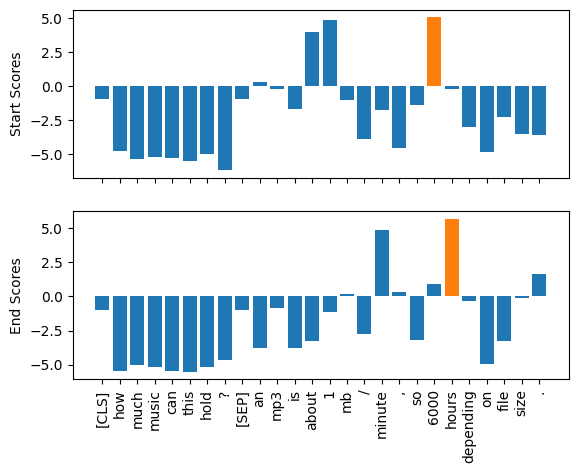

In [18]:
#id qa-scores
#caption Predicted logits for the start and end tokens; the token with the highest score is colored in orange

# The idea for this visualisation comes from https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

we see that there are two logits (a start and end) associated with each input token. As
illustrated in Figure 7-6, larger, positive logits correspond to more likely candidates
for the start and end tokens. In this example we can see that the model assigns the
highest start token logits to the numbers “1” and “6000”, which makes sense since our
question is asking about a quantity. Similarly, we see that the end tokens with the
highest logits are “minute” and “hours”.

To get the final answer, we can compute the argmax over the start and end token log‐
its and then slice the span from the inputs. The following code performs these steps
and decodes the result so we can print the resulting text:

In [19]:
import torch
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


Great, it worked! In Transformers, all of these preprocessing and postprocessing
steps are conveniently wrapped in a dedicated pipeline. We can instantiate the pipe‐
line by passing our tokenizer and fine-tuned model as follows:

In [20]:
from transformers import pipeline
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651614844799042, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082969546318054,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253532975912094,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In addition to the answer, the pipeline also returns the model’s probability estimate in
the score field (obtained by taking a softmax over the logits). This is handy when we
want to compare multiple answers within a single context.

In [21]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

## Dealing with long passages

One subtlety faced by reading comprehension models is that the context often con‐
tains more tokens than the maximum sequence length of the model (which is usually
a few hundred tokens at most).

a decent portion of the
SubjQA training set contains question-context pairs that won’t fit within MiniLM’s
context size of 512 tokens.

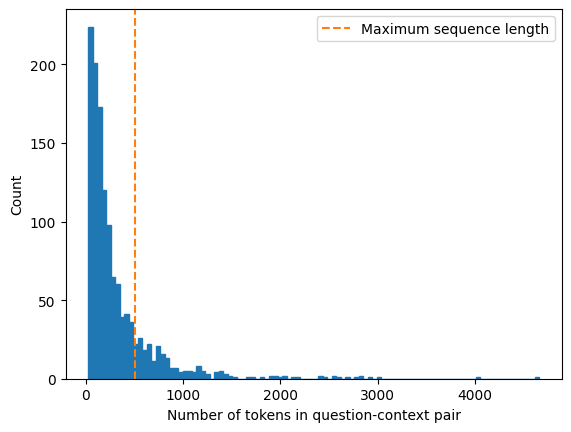

In [22]:

#hide_input
#id subjqa-dist
#caption Distribution of tokens for each question-context pair in the SubjQA training set
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1",
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

For other tasks, like text classification, we simply truncated long texts under the
assumption that enough information was contained in the embedding of the [CLS]
token to generate accurate predictions. For QA, however, this strategy is problematic
because the answer to a question could lie near the end of the context and thus would
be removed by truncation.

the standard way to deal with
this is to apply a sliding window across the inputs, where each window contains a pas‐
sage of tokens that fit in the model’s context.

In Transformers, we can set return_overflowing_tokens=True in the tokenizer to
enable the sliding window. The size of the sliding window is controlled by the
max_seq_length argument, and the size of the stride is controlled by doc_stride.

Let’s grab the first example from our training set and define a small window to illus‐
trate how this works:

In [23]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
return_overflowing_tokens=True, max_length=100,
stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In this case we now get a list of input_ids, one for each window. Let’s check the num‐
ber of tokens we have in each window:

In [24]:
for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [25]:
# Finally, we can see where two windows overlap by decoding the inputs:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



let’s look at the other components we need to build an end-to-end QA pipeline.

# Using Haystack to Build a QA Pipeline

However, in reality our system’s users will only provide a question
about a product, so we need some way of selecting relevant passages from among all
the reviews in our corpus.



One way to do this would be to concatenate all the reviews
of a given product together and feed them to the model as a single, long context.
Although simple, the drawback of this approach is that the context can become
extremely long and thereby introduce an unacceptable latency for our users’ queries.


To handle this, modern QA systems are typically based on the retriever-reader archi‐
tecture, which has two main components:

**Retriever**

Responsible for retrieving relevant documents for a given query. Retrievers are
usually categorized as sparse or dense.

1. Sparse retrievers use word frequencies to
represent each document and query as a sparse vector

2. On the other hand, dense retrievers use encoders like transformers to repre‐
sent the query and document as contextualized embeddings (which are dense
vectors). These embeddings encode semantic meaning, and allow dense retriev‐
ers to improve search accuracy by understanding the content of the query.


**Reader**

Responsible for extracting an answer from the documents provided by the
retriever. The reader is usually a reading comprehension model,

To build our QA system, we’ll use the Haystack library developed by deepset, a Ger‐
man company focused on NLP. Haystack is based on the retriever-reader architec‐
ture, abstracts much of the complexity involved in building these systems, and
integrates tightly with Transformers.

there are two more components involved
when building a QA pipeline with Haystack:
1. Document store

A document-oriented database that stores documents and metadata which are
provided to the retriever at query time
2. Pipeline

Combines all the components of a QA system to enable custom query flows,
merging documents from multiple retrievers, and more

To initialize the document store, we first need to download and install Elasticsearch.
By following Elasticsearch’s guide,

12 we can grab the latest release for Linux with wget

and unpack it with the tar shell command:

In [29]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

Next we need to start the Elasticsearch server. Since we’re running all the code in this
book within Jupyter notebooks, we’ll need to use Python’s Popen() function to spawn a new process. While we’re at it, let’s also run the subprocess in the background using
the chown shell command:

In [30]:
import os
from subprocess import Popen, PIPE, STDOUT
# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

By default, Elasticsearch runs locally on port 9200, so we can test
the connection by sending an HTTP request to localhost:

In [31]:
!curl -X GET "localhost:9200/"


curl: (7) Failed to connect to localhost port 9200 after 2 ms: Connection refused


In [36]:
!cat /content/elasticsearch-7.9.2/config/elasticsearch.yml | grep "http.port"


#http.port: 9200


In [35]:
%%bash
!netstat -tuln | grep LISTEN


bash: line 1: !netstat: command not found


CalledProcessError: Command 'b'!netstat -tuln | grep LISTEN\n'' returned non-zero exit status 1.

In [33]:
%%bash

ps -ef | grep elasticsearch

daemon     23350   22367 88 11:46 ?        00:00:27 /content/elasticsearch-7.9.2/jdk/bin/java -Xshar
daemon     23585   23350  0 11:46 ?        00:00:00 /content/elasticsearch-7.9.2/modules/x-pack-ml/p
root       23684   23682  0 11:46 ?        00:00:00 grep elasticsearch


Now that our Elasticsearch server is up and running, the next thing to do is instanti‐
ate the document store:

In [ ]:
#pip install haystack-ai
#!pip install elasticsearch-haystack
#!pip install farm-haystack
#!pip show elasticsearch
#!pip install elasticsearch-haystack
!pip install farm-haystack[elasticsearch]


daemon     23350   22367 88 11:46 ?        00:00:27 /content/elasticsearch-7.9.2/jdk/bin/java -Xshar
daemon     23585   23350  0 11:46 ?        00:00:00 /content/elasticsearch-7.9.2/modules/x-pack-ml/p
root       23681   23679  0 11:46 ?        00:00:00 grep elasticsearch


In [116]:
from elasticsearch import Elasticsearch

# Connect to the running Elasticsearch 8.11.1 instance
es = Elasticsearch(
    hosts=["http://localhost:9200"],
    verify_certs=False
)

# Test the connection
if es.ping():
    print("Elasticsearch 8.11.1 is running!")
else:
    print("Could not connect to Elasticsearch 8.11.1.")


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_transport.py", line 342, in perform_request
    resp = node.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_node/_http_urllib3.py", line 202, in perform_request
    raise err from None
elastic_transport.ConnectionError: Connection error caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7837c84b2260>: Failed to establish a new connection: [Errno 111] Connection refused)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_transport.py", line 342, in perform_request
    resp = node.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elastic_transport/_node/_http_urllib3.py", line 202, in perform_request
    raise err from None
elastic_transport.ConnectionError: Connection error caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7837c84b24a

Could not connect to Elasticsearch 8.11.1.


In [37]:
%%bash

curl -sX GET "localhost:9200/"

CalledProcessError: Command 'b'\ncurl -sX GET "localhost:9200/"\n'' returned non-zero exit status 7.

In [81]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore
#from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack import Document
# Return the document embedding for later use with dense retriever
#document_store = ElasticsearchDocumentStore()
document_store = ElasticsearchDocumentStore(return_embedding=True)


In [ ]:
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")

By default, ElasticsearchDocumentStore creates two indices on Elasticsearch: one
called document for (you guessed it) storing documents, and another called label for
storing the annotated answer spans. For now, we’ll just populate the document index with the SubjQA reviews, and Haystack’s document stores expect a list of dictionaries
with text and meta keys


The fields in meta can be used for applying filters during retrieval. For our purposes
we’ll include the item_id and q_review_id columns of SubjQA so we can filter by
product and question ID, along with the corresponding training split. We can then
loop through the examples in each DataFrame and add them to the index with the
write_documents() method as follows:

In [ ]:

for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs)

print(f"Loaded {document_store.get_document_count()} documents")

In [45]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab,inference]

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.23.2 requires pillow>=9.1, but you have pillow 9.0.0 which is incompatible.


# Initializing a retriever

The Elasticsearch document store can be paired with any of the Haystack retrievers,
so let’s start by using a sparse retriever based on BM25 (short for “Best Match 25”).
BM25 is an improved version of the classic Term Frequency-Inverse Document Fre‐
quency (TF-IDF) algorithm and represents the question and context as sparse vectors
that can be searched efficiently on Elasticsearch.

The BM25 score measures how
much matched text is about a search query and improves on TF-IDF by saturating TF
values quickly and normalizing the document length so that short documents are
favored over long ones.13

In Haystack, the BM25 retriever is used by default in ElasticsearchRetriever, so
let’s initialize this class by specifying the document store we wish to search over:

In [ ]:
from haystack.retriever.sparse import ElasticsearchRetriever
es_retriever = ElasticsearchRetriever(document_store=document_store)

Next, let’s look at a simple query for a single electronics product in the training set.
For review-based QA systems like ours, it’s important to restrict the queries to a single
item because otherwise the retriever would source reviews about products that are
not related to a user’s query. For example, asking “Is the camera quality any good?”
without a product filter could return reviews about phones, when the user might be
asking about a specific laptop camera instead.

By themselves, the ASIN values in our
dataset are a bit cryptic, but we can decipher them with online tools like amazon
ASIN or by simply appending the value of item_id to the www.amazon.com/dp/ URL.
The following item ID corresponds to one of Amazon’s Fire tablets, so let’s use the
retriever’s retrieve() method to ask if it’s any good for reading with:

In [ ]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

Here we’ve specified how many documents to return with the top_k argument and
applied a filter on both the item_id and split keys that were included in the meta
field of our documents. Each element of retrieved_docs is a Haystack Document
object that is used to represent documents and includes the retriever’s query score
along with other metadata. Let’s have a look at one of the retrieved documents:

In [ ]:
print(retrieved_docs[0])

In addition to the document’s text, we can see the score that Elasticsearch computed
for its relevance to the query (larger scores imply a better match). Under the hood,
Elasticsearch relies on Lucene for indexing and search, so by default it uses Lucene’s
practical scoring function. in brief terms it first filters the can‐
didate documents by applying a Boolean test (does the document match the query?),and then applies a similarity metric that’s based on representing both the document
and the query as vectors.

Now that we have a way to retrieve relevant documents, the next thing we need is a
way to extract answers from them. This is where the reader comes in, so let’s take a
look at how we can load our MiniLM model in Haystack.

# Initializing a reader

### FARMReader
Based on deepset’s FARM framework for fine-tuning and deploying transform‐
ers. Compatible with models trained using Transformers and can load models
directly from the Hugging Face Hub.

### TransformersReader
Based on the QA pipeline from Transformers. Suitable for running inference
only.

Since we will be fine-tuning the reader later in the chapter, we’ll use the FARMReader.
As with Transformers, to load the model we just need to specify the MiniLM
checkpoint on the Hugging Face Hub along with some QA-specific arguments:

In [ ]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2" #alternative larger models: deepset/roberta-base-squad2-distilled or deepset/xlm-roberta-large-squad2 or the tiny distilled model: deepset/tinyroberta-squad2
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

In [ ]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))


Putting it all together


In [ ]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

Now, you can specify the name of the node, e.g., "Retriever", that you want to pass parameters to.



In [ ]:
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"item_id": [item_id], "split":["train"]}},
                                      "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Great, we now have an end-to-end QA system for Amazon product reviews! This is a
good start, but notice that the second and third answers are closer to what the ques‐
tion is actually asking. To do better, we’ll need some metrics to quantify the perfor‐
mance of the retriever and reader. We’ll take a look at that next.

# Improving Our QA Pipeline

In particular, the
retriever sets an upper bound on the performance of the whole QA system, so it’s
important to make sure it’s doing a good job. With this in mind, let’s start by intro‐
ducing some common metrics to evaluate the retriever so that we can compare the
performance of sparse and dense representations.

Evaluating the Retriever
A common metric for evaluating retrievers is recall, which measures the fraction of all
relevant documents that are retrieved. In this context, “relevant” simply means
whether the answer is present in a passage of text or not, so given a set of questions,
we can compute recall by counting the number of times an answer appears in the top
k documents returned by the retriever.

In Haystack, there are two ways to evaluate retrievers:
• Use the retriever’s in-built eval() method. This can be used for both open- and
closed-domain QA, but not for datasets like SubjQA where each document is
paired with a single product and we need to filter by product ID for every query.
• Build a custom Pipeline that combines a retriever with the EvalRetriever class.
This enables the implementation of custom metrics and query flows.

In [ ]:


from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [ ]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})
        labels.append(label)

In [ ]:
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

In [ ]:

labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

In [ ]:

# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [ ]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")


In [ ]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "content", "gold_document_contents", "document_id", "gold_document_ids", "gold_id_match"]]


Or if we want to calculate metrics for multiple topk values, we can run the pipeline only once with the highest top_k value and calculate metrics for smaller top_ks afterwards.



In [ ]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in topk_values:
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(bm25_retriever)

In [ ]:

def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([bm25_topk_df], ["BM25"])

From the plot, we can see that there’s an inflection point around k = 5 and we get
almost perfect recall from k = 10 onwards. Let’s now take a look at retrieving docu‐
ments with dense vector techniques.

# Dense Passage Retrieval

We’ve seen that we get almost perfect recall when our sparse retriever returns k = 10
documents, but can we do better at smaller values of k? The advantage of doing so is
that we can pass fewer documents to the reader and thereby reduce the overall
latency of our QA pipeline. A well-known limitation of sparse retrievers like BM25 is
that they can fail to capture the relevant documents if the user query contains terms
that don’t match exactly those of the review. One promising alternative is to use dense
embeddings to represent the question and document, and the current state of the art
is an architecture known as Dense Passage Retrieval (DPR).14

The main idea behind
DPR is to use two BERT models as encoders for the question and the passage. As
illustrated in Figure 7-10, these encoders map the input text into a d-dimensional
vector representation of the [CLS] token.

In Haystack, we can initialize a retriever for DPR in a similar way to what we did for
BM25. In addition to specifying the document store, we also need to pick the BERT
encoders for the question and passage. These encoders are trained by giving them
questions with relevant (positive) passages and irrelevant (negative) passages, where
the goal is to learn that relevant question-passage pairs have a higher similarity. For
our use case, we’ll use encoders that have been fine-tuned on the NQ corpus in this
way:

In [ ]:
from haystack.retriever.dense import DensePassageRetriever
dpr_retriever = DensePassageRetriever(document_store=document_store,
query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
embed_title=False)

Once we’ve initialized the dense retriever, the next step is to iterate over all the
indexed documents in our Elasticsearch index and apply the encoders to update the
embedding representation. This can be done as follows:

In [ ]:
document_store.update_embeddings(retriever=dpr_retriever)

We’re now set to go! We can evaluate the dense retriever in the same way we did for
BM25 and compare the top-k recall:

In [ ]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([es_topk_df, dpr_topk_df], ["BM25", "DPR"])

Here we can see that DPR does not provide a boost in recall over BM25 and saturates
around k = 3.

# Evaluating the Reader
In extractive QA, there are two main metrics that are used for evaluating readers:

1. Exact Match (EM)

A binary metric that gives EM = 1 if the characters in the predicted and ground
truth answers match exactly, and EM = 0 otherwise. If no answer is expected, the
model gets EM = 0 if it predicts any text at all.

2. F1 -score

Measures the harmonic mean of the precision and recall.

In [ ]:
from farm.evaluation.squad_evaluation import compute_f1, compute_exact
pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")
EM: 0
F1: 0.8

Under the hood, these functions first normalize the prediction and label by removing
punctuation, fixing whitespace, and converting to lowercase. The normalized strings
are then tokenized as a bag-of-words, before finally computing the metric at the
token level. From this simple example we can see that EM is a much stricter metric
than the F1
-score:

adding a single token to the prediction gives an EM of zero. On the
other hand, the F1

-score can fail to catch truly incorrect answers. For example, if our

predicted answer span is “about 6000 dollars”, then we get:

In [ ]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

Relying on just the F1

-score is thus misleading, and tracking both metrics is a good
strategy to balance the trade-off between underestimating (EM) and overestimating
(F1
-score) model performance.

To evaluate the reader we’ll create a new pipeline with two nodes: a reader node and a
node to evaluate the reader. We’ll use the EvalReader class that takes the predictions
from the reader and computes the corresponding EM and F1

scores. To compare with
the SQuAD evaluation, we’ll take the best answers for each query with the top_1_em
and top_1_f1 metrics that are stored in EvalAnswers:

In [ ]:

from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

Notice that we specified skip_incorrect_retrieval=False. This is to ensure that
the retriever always passes the context to the reader (as in the SQuAD evaluation).
Now that we’ve run every question through the reader, let’s print the scores:

In [ ]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

OK, it seems that the fine-tuned model performs significantly worse on SubjQA than
on SQuAD 2.0, where MiniLM achieves EM and F1

scores of 76.1 and 79.5, respec‐
tively. One reason for the performance drop is that customer reviews are quite differ‐
ent from the Wikipedia articles the SQuAD 2.0 dataset is generated from, and the
language they use is often informal. Another factor is likely the inherent subjectivity
of our dataset, where both questions and answers differ from the factual information
contained in Wikipedia. Let’s look at how to fine-tune a model on a dataset to get bet‐
ter results with domain adaptation.

# Domain Adaptation

Although models that are fine-tuned on SQuAD will often generalize well to other
domains, we’ve seen that for SubjQA the EM and F1

scores of our model were much
worse than for SQuAD. This failure to generalize has also been observed in other
extractive QA datasets and is understood as evidence that transformer models are
particularly adept at overfitting to SQuAD.15 The most straightforward way to
improve the reader is by fine-tuning our MiniLM model further on the SubjQA train‐
ing set. The FARMReader has a train() method that is designed for this purpose and
expects the data to be in SQuAD JSON format, where all the question-answer pairs
are grouped together for each item

This is quite a complex data format, so we’ll need a few functions and some Pandas
magic to help us do the conversion. The first thing we need to do is implement a
function that can create the paragraphs array associated with each product ID. Each
element in this array contains a single context (i.e., review) and a qas array of
question-answer pairs. Here’s a function that builds up the paragraphs array:

In [ ]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid,
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

Now, when we apply to the rows of a DataFrame associated with a single product ID,
we get the SQuAD format:

In [ ]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

The final step is to then apply this function to each product ID in the DataFrame of
each split. The following convert_to_squad() function does this trick and stores the
result in an electronics-{split}.json file:

In [ ]:

import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)

convert_to_squad(dfs)

Now that we have the splits in the right format, let’s fine-tune our reader by specify‐
ing the locations of the train and dev splits, along with where to save the fine-tuned
model:

In [ ]:

train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

In [ ]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)


Wow, domain adaptation has increased our EM score by a factor of six and more than
doubled the F1

-score! At this point, you might be wondering why we didn’t just fine-
tune a pretrained language model directly on the SubjQA training set. One reason is

that we only have 1,295 training examples in SubjQA while SQuAD has over 100,000,
so we might run into challenges with overfitting. Nevertheless, let’s take a look at what
naive fine-tuning produces.

For a fair comparison, we’ll use the same language model that was used for fine-tuning our baseline on SQuAD. As before, we’ll load up the
model with the FARMReader:

In [ ]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

Next, we fine-tune for one epoch:

In [ ]:

minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

and include the evaluation on the test set:

In [ ]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)


In [ ]:
plot_reader_eval(reader_eval)


We can see that fine-tuning the language model directly on SubjQA results in consid‐
erably worse performance than fine-tuning on SQuAD and SubjQA.

# Evaluating the Whole QA Pipeline


Now that we’ve seen how to evaluate the reader and retriever components individu‐
ally, let’s tie them together to measure the overall performance of our pipeline. To do
so, we’ll need to augment our retriever pipeline with nodes for the reader and its evaluation. We’ve seen that we get almost perfect recall at k = 10, so we can fix this
value and assess the impact this has on the reader’s performance (since it will now
receive multiple contexts per query compared to the SQuAD-style evaluation):

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

In [ ]:
#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"],
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

We can then compare the top 1 EM and F1

scores for the model to predict an answer

in the documents returned by the retriever in Figure

In [ ]:

# Or get QA pipeline and Reader metrics in one shot:
# Reader evaluation is run a second time using simulated perfect retriever results
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader run in isolation with simulated perfect retriever
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

From this plot we can see the effect that the retriever has on the overall performance.

In particular, there is an overall degradation compared to matching the question-
context pairs, as is done in the SQuAD-style evaluation. This can be circumvented by

increasing the number of possible answers that the reader is allowed to predict.

# Retrieval-Augmented Generation

In this section
we’ll briefly touch on the current state of the art: retrieval-augmented generation

RAG extends the classic retriever-reader architecture that we’ve seen in this chapter
by swapping the reader for a generator and using DPR as the retriever. The generator
is a pretrained sequence-to-sequence transformer like T5 or BART that receives latent
vectors of documents from DPR and then iteratively generates an answer based on
the query and these documents. Since DPR and the generator are differentiable, the
whole process can be fine-tuned end-to-end

To show RAG in action we’ll use the DPRetriever from earlier, so we just need to
instantiate a generator. There are two types of RAG models to choose from:

1. RAG-Sequence
Uses the same retrieved document to generate the complete answer. In particular,
the top k documents from the retriever are fed to the generator, which produces
an output sequence for each document, and the result is marginalized to obtain
the best answer.

2. RAG-Token
Can use a different document to generate each token in the answer. This allows
the generator to synthesize evidence from multiple documents.

Since RAG-Token models tend to perform better than RAG-Sequence ones, we’ll use
the token model that was fine-tuned on NQ as our generator. Instantiating a genera‐
tor in Haystack is similar to instantiating the reader, but instead of specifying the
max_seq_length and doc_stride parameters for a sliding window over the contexts,
we specify hyperparameters that control the text generation:

In [ ]:

from haystack.nodes import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

The next thing to do is tie

In [ ]:

from haystack.pipelines import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

Let’s now give RAG a spin by feeding in some queries about the Amazon Fire tablet
from before. To simplify the querying, we’ll write a simple function that takes the
query and prints out the top answers:

In [ ]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query,
                     params={"Retriever": {"top_k":5,
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx].answer}")

In [ ]:
generate_answers(query)


In [ ]:
generate_answers("What is the main drawback?")


To get better results we could fine-tune RAG end-to-end on
SubjQA; we’ll leave this as an exercise, but if you’re interested in exploring it there are
scripts in the Transformers repository to help you get started.

# Conclusion

Well, that was a whirlwind tour of QA, and you probably have many more questions
that you’d like answered (pun intended!). In this chapter, we discussed two
approaches to QA (extractive and generative) and examined two different retrieval
algorithms (BM25 and DPR). Along the way, we saw that domain adaptation can be a
simple technique to boost the performance of our QA system by a significant margin,
and we looked at a few of the most common metrics that are used for evaluating such
systems. Although we focused on closed-domain QA (i.e., a single domain of elec‐

tronic products), the techniques in this chapter can easily be generalized to the open-
domain case; we recommend reading Cloudera’s excellent Fast Forward QA series to

see what’s involved.

Deploying QA systems in the wild can be a tricky business to get right, and our expe‐
rience is that a significant part of the value comes from first providing end users with
useful search capabilities, followed by an extractive component. In this respect, the
reader can be used in novel ways beyond answering on-demand user queries. For
example, researchers at Grid Dynamics were able to use their reader to automatically
extract a set of pros and cons for each product in a client’s catalog. They also showed
that a reader can be used to extract named entities in a zero-shot fashion by creating
queries like “What kind of camera?” Given its infancy and subtle failure modes, we
recommend exploring generative QA only once the other two approaches have been
exhausted. This “hierarchy of needs” for tackling QA problems

Looking ahead, one exciting research area is multimodal QA, which involves QA over
multiple modalities like text, tables, and images. As described in the MultiModalQA
benchmark,17 such systems could enable users to answer complex questions that inte‐
grate information across different modalities, like “When was the famous painting
with two touching fingers completed?” Another area with practical business applica‐

tions is QA over a knowledge graph, where the nodes of the graph correspond to real-
world entities and their relations are defined by the edges. By encoding factoids as

(subject, predicate, object) triples, one can use the graph to answer questions about a
missing element. For an example that combines transformers with knowledge graphs,
see the Haystack tutorials. One more promising direction is automatic question gener‐
ation as a way to do some form of unsupervised/weakly supervised training using
unlabeled data or data augmentation. Two recent examples include the papers on the
Probably Answered Questions (PAQ) benchmark and synthetic data augmentation
for cross-lingual settings.18

In this chapter we’ve seen that in order to successfully use QA models for real-world
use cases we need to apply a few tricks, such as implementing a fast retrieval pipeline
to make predictions in near real time. Still, applying a QA model to a handful of pre‐
selected documents can take a couple of seconds on production hardware. Although
this may not sound like much, imagine how different your experience would be if you
had to wait a few seconds to get the results of a Google search—a few seconds of wait
time can decide the fate of your transformer-powered application. In the next chapter
we’ll have a look at a few methods to accelerate model predictions further.